In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web


Estadisticos de la distribucion logaritmica
Media:  0.0004
Varianza:  0.0004
Asimetria:  0.815
Curtosis:  20.2986
-------------------------------------------------------------------
Percentage Values of VaRs
99% 1-day Student t VaR = -3.840%
99% 1-day Normal VaR    = -4.426%
------------------------------------------------------------------------
------------------------------------------------------------------------
Monetary amount of Loss according to Normal VaR given 10000 dollares:
 
432.98
------------------------------------------------------------------------
Monetary amount of Loss according to t-Student VaR given 10000 bucks:
 
376.74
------------------------------------------------------------------------
------------------------------------------------------------------------
99% 1-day Normal CVaR  = -5.077%
99% 1-day t-Student CVaR  = -5.342%
------------------------------------------------------------------------
Monetary amount of Loss according to Normal CVaR given 1000

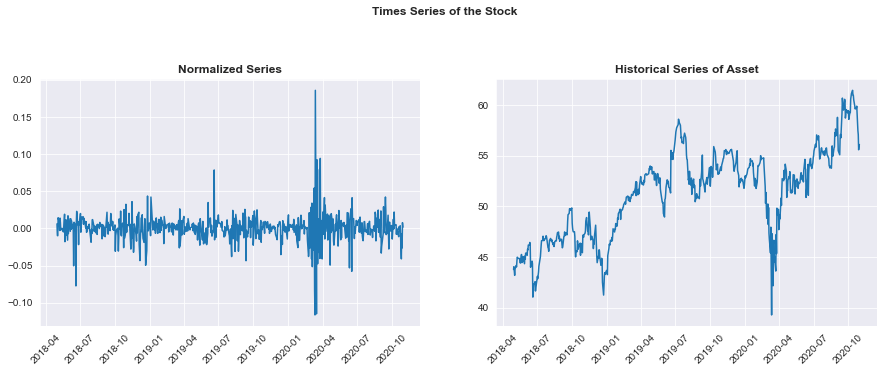

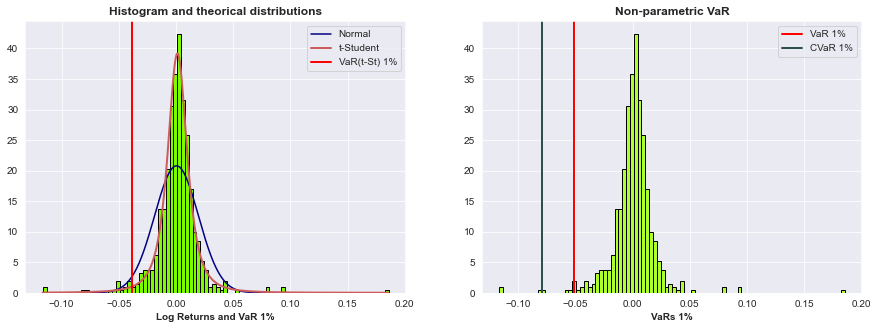

Percentile value = -5.119%
Historical Value-at-Risk given 10000 bucks:
The VaR for this asset in monetary terms is 498.98%
-----------------------------------------------------------
Historical Conditional Value-at-Risk given 10000 bucks:
Percentile value = -7.92%
-----------------------------------------------------------
Monetary amount of Loss using Historical CVaR for this asset is:
761.56


In [5]:
un_resplandor_pum('ORCL', '2018-04-30', '2020-10-30', investment=10000)

In [3]:
def un_resplandor_pum(firm: str, start: str, end: str,
            investment: float) -> (str, float, bool):

    import pandas_datareader.data as web
    import scipy.stats as sps
    from seaborn import set_style
    set_style('darkgrid')

    firm = firm
    c1 = start
    c2 = end
    investment = investment
    f3 = web.DataReader(firm, 'yahoo', c1, c2)['Adj Close']
    f3_log = np.log(f3 / f3.shift(1)).dropna()
    w1, w2, w3, w4, w5, w6 = sps.describe(f3_log)
    print('Estadisticos de la distribucion logaritmica')
    print('Media: ',round(w3, 4))
    print('Varianza: ', round(w4, 4))
    print('Asimetria: ', round(w5, 4))
    print('Curtosis: ', round(w6, 4))
    print('-------------------------------------------------------------------')
    x = np.linspace(np.min(f3_log), np.max(f3_log), 1000)
    

    mu_norm, sig_norm = sps.norm.fit(f3_log)
    zeta = sps.norm.ppf(.01)
    pdf_nor = sps.norm.pdf(x, mu_norm, sig_norm)
    nu, mu_t, sig_t = sps.t.fit(f3_log)
    pdf_t = sps.t.pdf(x, nu, mu_t, sig_t)

    h = 1  # days
    alpha = .01  # significance level
    StudenthVaR = h * mu_norm - (h * (nu - 2) / nu) ** 0.5 * sps.t.ppf(1 - alpha, nu) * sig_norm
    NormalhVaR = h * mu_norm - sps.norm.ppf(1 - alpha) * sig_norm * (h ** 0.5)

    lev = 100 * (1 - alpha)
    print('Percentage Values of VaRs')
    print("%g%% %g-day Student t VaR = %.3f%%" % (lev, h, StudenthVaR * 100))
    print("%g%% %g-day Normal VaR    = %.3f%%" % (lev, h, NormalhVaR * 100))

    print('------------------------------------------------------------------------')
    print('------------------------------------------------------------------------')
    print(f'Monetary amount of Loss according to Normal VaR given {investment} dollares:\n ')
    sa = ((1 - np.exp(NormalhVaR)) * investment)
    print(round(sa, 2))
    print('------------------------------------------------------------------------')
    print(f'Monetary amount of Loss according to t-Student VaR given {investment} bucks:\n ')
    print(round((1 - np.exp(StudenthVaR)) * investment, 2))
    print('------------------------------------------------------------------------')
    print('------------------------------------------------------------------------')
    z = (1 / alpha * 1 / np.sqrt(2 * np.pi) * np.exp(-.5 * zeta ** 2))  # Normale
    CVaR_normale = mu_norm - sig_norm * z
    print("%g%% %g-day Normal CVaR  = %.3f%%" % (lev, h, CVaR_normale * 100))
    Cvar_t = mu_t + sig_t * sps.t.ppf(.01, nu)
    print("%g%% %g-day t-Student CVaR  = %.3f%%" % (lev, h, Cvar_t * 100))
    CVaR_norm = ((1 - np.exp(CVaR_normale)) * investment)
    print('------------------------------------------------------------------------')
    print(f'Monetary amount of Loss according to Normal CVaR given {investment}:\n ')
    print(CVaR_norm.round(2))
    print(f'Monetary amount of Loss according to t-Stud CVaR given {investment}:\n ')
    valor = (1 - np.exp(Cvar_t)) * investment
    print(round(valor, 2))
    print('--'*30)
    print('--'*30)
    order = f3_log.sort_values(ascending=True)
    valu = np.percentile(order, 1)
    print(f'Percentile value {round(valu * 100, 3)}')
    var01 = ((1 - np.exp(valu)) * investment)
    print(f'Historical Value-at-Risk given {investment} bucks:\n'
              f'The VaR for this asset in monetary terms is {round(var01, 2)}')
    print('-----------------------------------------------------------')
    cvar = (order[order <= valu]).mean()
    print(f'Historical Conditional Value-at-Risk given {investment} bucks:\n'
              f'Percentile value {round(cvar * 100, 2)}%')
    print('-----------------------------------------------------------')
    print('Monetary amount of Loss using Historical CVaR for this asset is:')
    money = (1 - np.exp(cvar)) * investment
    print(money.round(2))
    print('--'*30)


        # Graphs
    plt.figure(figsize=(15,10))
    plt.suptitle('Times Series of the Stock', fontweight='bold')
    p0 = plt.subplot(2, 2, 1)
    plt.title('Normalized Series', fontweight='bold')
    p0.plot(f3_log)
    plt.xticks(rotation=45)
    p1 = plt.subplot(2, 2, 2)
    plt.title('Historical Series of Asset', fontweight='bold')
    p1.plot(f3)
    plt.xticks(rotation=45)

    plt.figure(figsize=(15,5))
    p2 = plt.subplot(1, 2, 1)
    plt.title('Histogram and theorical distributions', fontweight='bold')
    p2.hist(f3_log, edgecolor='black', color='lawngreen',
                 bins='fd', density=True)
    p2.plot(x, pdf_nor, label='Normal', color='navy')
    p2.plot(x, pdf_t, label='t-Student', color='indianred', linewidth=2)
    plt.xlabel('Log Returns and VaR 1%', fontweight='bold')
    p2.axvline(StudenthVaR, label='VaR(t-St) 1%', color='red', linewidth=2)
    plt.legend()
    p3 = plt.subplot(1,2,2)
    plt.title('Non-parametric VaR', fontweight='bold')
    plt.xlabel('VaRs 1%', fontweight='bold')
    p3.hist(f3_log, edgecolor='black', color='greenyellow', bins='fd', density=True)
    p3.axvline(valu, label='VaR 1%', color='red', linewidth=2)
    p3.axvline(cvar, label='CVaR 1%', color='darkslategrey', linewidth=2)
    plt.legend()
    plt.show()

    order = f3_log.sort_values(ascending=True)
    valu = np.percentile(order, 1)
    print(f'Percentile value = {round(valu * 100, 3)}%')
    var01 = ((1 - np.exp(valu)) * investment)
    print(f'Historical Value-at-Risk given {investment} bucks:\n'
              f'The VaR for this asset in monetary terms is {round(var01, 2)}%')
    print('-----------------------------------------------------------')
    cvar = (order[order <= valu]).mean()
    print(f'Historical Conditional Value-at-Risk given {investment} bucks:\n'
              f'Percentile value = {round(cvar * 100, 2)}%')
    print('-----------------------------------------------------------')
    print('Monetary amount of Loss using Historical CVaR for this asset is:')
    money = (1 - np.exp(cvar)) * investment
    print(money.round(2))


        